# Intersection with a crosswalk

**Load dependencies**

In [11]:
rng = MersenneTwister(1);

In [2]:
using AutomotivePOMDPs
using MDPModelChecking

The method will not be callable.


In [3]:
using GridInterpolations, StaticArrays, POMDPs, POMDPToolbox, AutoViz, AutomotiveDrivingModels, Reel
using DiscreteValueIteration, DeepQLearning, DeepRL
using ProgressMeter, Parameters, JLD

In [15]:
include("masking_backup.jl")
include("util.jl")
include("masked_dqn.jl")
include("render_helpers.jl")

## Scenario in the Continuous Space

In [5]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =  [VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

## Discrete Fully Observable Abstraction

In [6]:
mdp = PedMDP(env = env, vel_res=2., pos_res=2., ped_type=VehicleDef(AgentClass.PEDESTRIAN, 1.0, 3.0), ped_birth=0.7)
labels = labeling(mdp);

**Print some model information**

In [7]:
@printf("spatial resolution %2.1f m \n", mdp.pos_res)
@printf("pedestrian velocity resolution %2.1f m/s \n", mdp.vel_ped_res)
@printf("car velocity resolution %2.1f m/s \n", mdp.vel_res)
@printf("number of states %d \n", n_states(mdp))
@printf("number of actions %d \n", n_actions(mdp))

spatial resolution 2.0 m 
pedestrian velocity resolution 1.0 m/s 
car velocity resolution 2.0 m/s 
number of states 29580 
number of actions 4 


**Parse Model with Storm**

In [8]:
property = "Pmax=? [ (!\"crash\") U \"goal\"]" 
# property = "Pmax=? [G!\"crash\"]"
# property = "Pmax=? [ G!\"crash\" & F<=30\"goal\"]" 
# property = "multi(Pmax=? [ G !\"crash\" ], Pmax=? [ F<=30 \"goal\" ])"

"Pmax=? [ (!\"crash\") U \"goal\"]"

In [9]:
result = model_checking(mdp, labels, property, transition_file_name="pedmdp3.tra", labels_file_name="pedmdp3.lab", overwrite=true);

28-Jun 00:45:47:WARNING:root:overwriting potential existing files!


In [10]:
P = get_proba(mdp, result);
threshold = 0.9999
mask = nothing
mask_file = "pedmask3.jld"
if isfile(mask_file) && false
    println("Loading safety mask from pedmask_nb.jld")
    mask_data = JLD.load(mask_file)
    mask = mask_data["mask"]
else
    println("Computing safety mask...")
    mask = SafetyMask(mdp, StormPolicy(mdp, result), threshold)
    JLD.save(mask_file, "mask", mask)
    println("Mask saved to $mask_file")
end
;

Computing safety mask...
Mask saved to pedmask3.jld


In [11]:
# solver = ValueIterationSolver(max_iterations=1000)
# mdp.collision_cost = -1
# vi_policy = nothing 
# if isfile("ped_vi_policy.jld")
#     println("Loading VI policy from ped_vi_policy.jld")
#     policy_data = JLD.load("ped_vi_policy.jld")
#     vi_policy = policy_data["policy"]
# else
#     println("Computing policy using VI...")
#     vi_policy = solve(solver, mdp, verbose=true)
#     JLD.save("ped_vi_policy.jld", "policy", vi_policy)
#     println("Policy saved to ped_vi_policy.jld")
# end
# ;

In [12]:
rand_pol = MaskedEpsGreedyPolicy(mdp, 1.0, mask, rng);

In [13]:
# rng = MersenneTwister(2)
# hr = HistoryRecorder(rng=rng, max_steps=100)
# s0 = initialstate(mdp, rng)
# @time hist = simulate(hr, mdp, vi_policy, s0);
# rng = MersenneTwister(2)
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(mdp, rng)
@time hist2 = simulate(hr, mdp, rand_pol, s0);

  1.475931 seconds (651.76 k allocations: 32.608 MiB, 2.38% gc time)


In [14]:
@time for ep=1:1000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initialstate(mdp, rng)
    hist2 = simulate(hr, mdp, rand_pol, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

 64.732461 seconds (100.45 M allocations: 4.697 GiB, 4.13% gc time)


In [47]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, PedMDPAction(0.))
duration, fps, render_hist = animate_states(mdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpvPItaJ", 0x0000000000000049, 2.0, nothing)

In [48]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(mdp, rand_pol, n_ep=1000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

 34.475313 seconds (91.68 M allocations: 4.356 GiB, 5.09% gc time)
Summary for 1000 episodes: 
Average reward: 0.039 
Average # of steps: 81.089 
Average # of violations: 0.000 


In [49]:
initial_probability(mdp, result)

0.9999918859906726

## Map to high fidelity environment

We must be able to compute the safe actions in the continuous space environment. 

Several approaches are possible:
- multi-linear interpolations of the states and weight the risk of the states: 
$$P_{\phi}(s, a) = \sum_{\text{interpolated states}}w_{itp}P_{\phi}(s_{itp}, a)$$
- most likely state 


In [22]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =  [VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);
pomdp = UrbanPOMDP(env=env,
                   ego_goal = LaneTag(2, 1),
                   max_cars=0, 
                   max_peds=1, 
                   car_birth=0.3, 
                   ped_birth=0.7, 
                   obstacles=false, # no fixed obstacles
                   lidar=false,
                   pos_obs_noise = 0., # fully observable
                   vel_obs_noise = 0.);
rand_pol = RandomMaskedPOMDPPolicy(mask, pomdp, rng);

28-Jun 10:12:37:WARNING:root:replacing docs for 'AutomotivePOMDPs.stop_at_dist :: Tuple{AutomotiveDrivingModels.DriverModel,Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},Float64}' in module 'AutomotivePOMDPs'.


In [23]:
include("masking_backup.jl")

In [25]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(pomdp, rng)
o0 = generate_o(pomdp, s0, rng)
up = FastPreviousObservationUpdater{UrbanObs}()
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0);

  0.129021 seconds (780.39 k allocations: 28.028 MiB, 13.98% gc time)


In [26]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
push!(action_hist, PedMDPAction(NaN))
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpj9zDfe", 0x000000000000002c, 2.0, nothing)

In [33]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

1718.825905 seconds (14.02 G allocations: 486.540 GiB, 17.93% gc time)
Summary for 10000 episodes: 
Average reward: 0.045 
Average # of steps: 77.004 
Average # of violations: 0.000 


In [21]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=10000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

1324.132022 seconds (14.67 G allocations: 510.827 GiB, 20.12% gc time)
Summary for 10000 episodes: 
Average reward: 0.036 
Average # of steps: 80.825 
Average # of violations: 0.000 


In [25]:
@time for ep=1:10000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initialstate(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end

1918.361417 seconds (14.10 G allocations: 489.207 GiB, 16.85% gc time)


In [67]:
function interpolate_state(mdp::PedMDP, s::PedMDPState)
    # interpolate s in the grid
    ped_v = get_ped_vspace(mdp.env, mdp.vel_ped_res) 
    itp_ped, itp_ped_w = interpolate_pedestrian(s.ped, ped_v)
    ego_v = get_car_vspace(mdp.env, mdp.vel_res)
    itp_ego, itp_ego_w = interpolate_state(s.ego, ego_v)
    itp_states = Vector{PedMDPState}(length(itp_ego)*length(itp_ped))
    itp_w = Vector{Float64}(length(itp_states))
    k = 1
    for (i, p) in enumerate(itp_ped)
        for (j, e) in enumerate(itp_ego)
            crash = is_colliding(Vehicle(p, mdp.ped_type, 0), Vehicle(e, mdp.ego_type, 1))
            itp_states[k] = PedMDPState(crash, e, p)
            itp_w[k] = itp_ped_w[i]*itp_ego_w[j]
            k += 1
        end
    end
    @assert sum(itp_w) ≈ 1.
    return itp_states, itp_w
end

function car_roadway(env::UrbanEnv)
    params = env.params
    intersection_params = TInterParams(params.x_min, params.x_max, params.y_min, params.inter_x,
                                    params.inter_y, params.inter_width, params.inter_height,
                                    params. lane_width, params.nlanes_main, params.nlanes,
                                    params. stop_line, params.speed_limit, params.car_rate)
    car_roadway = gen_T_roadway(intersection_params)
    return car_roadway
end

function get_pedmdp_state(mdp::PedMDP, s::Scene, ped_id::Int64)
    ped_i = findfirst(s, ped_id)
    ped = Vehicle(get_off_the_grid(mask.mdp), mdp.ped_type, ped_id)
    if ped_i != 0
        ped = s[ped_i]
    end
    ego = get_ego(s)
    e_state = VehicleState(ego.state.posG, car_roadway(mdp.env), ego.state.v)
    p_lane = get_lane(mdp.env.roadway, ped.state)
    if p_lane.tag ∈ [LaneTag(17,1), LaneTag(18,1), LaneTag(19,1)]
        if ped.state.posG.θ == 0. ||ped.state.posG.θ == float(pi) # solve ambiguity in projection
            p_lane = mdp.env.ped_roadway[LaneTag(19,1)]
        end
        p_state = VehicleState(ped.state.posG, p_lane, mdp.env.ped_roadway, ped.state.v)
    else
        p_state = VehicleState(ped.state.posG, mdp.env.ped_roadway, ped.state.v)
    end
    return PedMDPState(is_colliding(ego, ped), e_state, p_state)
end

LoadError: [91merror in method definition: function AutomotivePOMDPs.interpolate_state must be explicitly imported to be extended[39m

In [43]:
function render_interpolated_states(mdp::PedMDP, scene::Scene, ped_id=101)
    sp = deepcopy(scene)
    s = get_pedmdp_state(mdp, sp, ped_id)
    ped_v = get_ped_vspace(mdp.env, mdp.vel_ped_res) 
    itp_ped, itp_ped_w = interpolate_pedestrian(s.ped, ped_v)
    ego_v = get_car_vspace(mdp.env, mdp.vel_res)
    itp_ego, itp_ego_w = interpolate_state(s.ego, ego_v)
    colors = Dict{Int64, Colorant}(1=>COLOR_CAR_EGO, ped_id=>COLOR_CAR_OTHER)
    pid = ped_id+1
    for pi in itp_ped
        if pi.posG != mdp.off_grid
            push!(sp, Vehicle(pi, mdp.ped_type, pid))
            colors[pid] = MONOKAI["color2"]
            pid += 1            
        end
    end
    eid = EGO_ID+1
    for ei in itp_ego
        push!(sp, Vehicle(ei, mdp.ego_type, eid))
        colors[eid] = MONOKAI["color2"]
        eid += 1        
    end
    return AutoViz.render(sp, env, cam=FitToContentCamera(0.), car_colors = colors)    
end

mutable struct InterpolationOverlay <: SceneOverlay
    verbosity::Int
    color::Colorant
    font_size::Int
    id::Int
    mdp::PedMDP
    pomdp::UrbanPOMDP

    function InterpolationOverlay(mdp::PedMDP, pomdp::UrbanPOMDP, id::Int=101;
        verbosity::Int=1,
        color::Colorant=colorant"white",
        font_size::Int=20,
        )

        new(verbosity, color, font_size, id, mdp, pomdp)
    end
end

function AutoViz.render!(rendermodel::RenderModel, overlay::InterpolationOverlay, scene::Scene, env::OccludedEnv)
    transparency = 0.5
    s = get_pedmdp_state(overlay.mdp, scene, overlay.id)
    ped_v = get_ped_vspace(mdp.env, mdp.vel_ped_res) 
    itp_ped, itp_ped_w = interpolate_pedestrian(s.ped, ped_v)
    ego_v = get_car_vspace(mdp.env, mdp.vel_res)
    itp_ego, itp_ego_w = interpolate_state(s.ego, ego_v)
    for pi in itp_ped
        x, y, θ, v = pi.posG.x, pi.posG.y, pi.posG.θ, pi.v 
        color = RGBA(75./255, 66./255, 244./255, transparency)
        add_instruction!(rendermodel, render_vehicle, (x, y, θ, overlay.mdp.ped_type.length, overlay.mdp.ped_type.width, color, color, RGBA(1.,1.,1.,transparency)))
    end
    for ei in itp_ego
         x, y, θ, v = ei.posG.x, ei.posG.y, ei.posG.θ, ei.v 
        color = RGBA(75./255, 66./255, 244./255, transparency)
        add_instruction!(rendermodel, render_vehicle, (x, y, θ, overlay.mdp.ego_type.length, overlay.mdp.ego_type.width, color, color, RGBA(1.,1.,1.,transparency)))
    end    
end

In [44]:
# XXX uses global variable POMDP
function POMDPStorm.safe_actions(mask::SafetyMask{PedMDP, PedMDPAction}, o::UrbanObs, ped_id=101)
    s = obs_to_scene(pomdp, o)
    return safe_actions(mask, s, ped_id)
end
function POMDPStorm.safe_actions(mask::SafetyMask{PedMDP, PedMDPAction},s::UrbanState, ped_id=101)    
    s_mdp = get_pedmdp_state(mask.mdp, s, ped_id)
    itp_states, itp_weights = interpolate_state(mask.mdp, s_mdp)
    # compute risk vector
    p_sa = zeros(n_actions(mask.mdp))
    for (i, ss) in enumerate(itp_states)
        si = stateindex(mask.mdp, ss)
        p_sa += itp_weights[i]*mask.risk_mat[si,:]
    end
    safe_acts = PedMDPAction[]
    sizehint!(safe_acts, n_actions(mask.mdp))
    if maximum(p_sa) <= mask.threshold
        push!(safe_acts, mask.actions[argmax(p_sa)])
    else
        for (j, a) in enumerate(mask.actions)
            if p_sa[j] > mask.threshold
                push!(safe_acts, a)
            end
        end
    end
#     println("coucou ")
#     println("Safe acts $([a.acc for a in safe_acts])")
    return safe_acts
end

In [45]:
function POMDPToolbox.action_info{M}(policy::MaskedEpsGreedyPolicy{M}, s)
    return action(policy, s), safe_actions(policy.mask, s)
end

In [20]:
function animate_states(pomdp::UrbanPOMDP, states::Vector{UrbanState}, actions::Vector{UrbanAction}, mask::SafetyMask;
                        overlays=SceneOverlay[IDOverlay()],
                        cam=StaticCamera(VecE2(0, -5.), 17.))
    duration = length(states)*pomdp.ΔT
    fps = Int(1/pomdp.ΔT)    
    function render_states(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        scene = states[frame_index] #state2scene(mdp, states[frame_index])
        safe_acts =[a.acc for a in safe_actions(mask, states[frame_index])]
        return AutoViz.render(scene,
                pomdp.env,
                cat(1, overlays, InterpolationOverlay(mask.mdp, pomdp),
                                 TextOverlay(text = ["v: $(get_ego(scene).state.v)"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,6.),
                                            incameraframe=true),
                                 TextOverlay(text = ["Acc: $(actions[frame_index].acc)"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,8.),
                                            incameraframe=true),
                                TextOverlay(text = ["Available Actions: $safe_acts"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,10.),
                                            incameraframe=true),
                                TextOverlay(text = ["step: $frame_index"],
                                            font_size=20,
                                            pos=VecE2(pomdp.env.params.x_min + 3.,4.),
                                            incameraframe=true)),
                cam=cam,
                car_colors=get_colors(scene))
    end
    return duration, fps, render_states
end

animate_states (generic function with 3 methods)

In [50]:
sc = h.state_hist[5]
bc = h.belief_hist[5]
for veh in sc
    println(veh.state)
end
safe_actions(mask, bc)

VehicleState(VecSE2({1.500, -7.500}, 1.571), Frenet(RoadIndex({1, 0.865385}, {6, 1}), 22.500, 0.000, 0.000), 2.000)
VehicleState(VecSE2({6.247, -4.526}, 3.142), Frenet(RoadIndex({1, 0.946221}, {19, 1}), 13.247, 0.474, 3.142), 0.500)


1-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(2.0)

In [49]:
bs = obs_to_scene(pomdp, bc)
sbmdp = get_pedmdp_state(mdp, bs, 101)
for veh in bs 
    println(veh.state)
end
println(sbmdp.ped)

VehicleState(VecSE2({1.500, -7.500}, 1.571), Frenet(RoadIndex({1, 0.865385}, {6, 1}), 22.500, -0.000, 0.000), 2.000)
VehicleState(VecSE2({6.247, -4.526}, 3.142), Frenet(RoadIndex({1, 0.176689}, {17, 1}), 2.474, -0.247, 1.571), 0.500)
VehicleState(VecSE2({6.247, -4.526}, 3.142), Frenet(RoadIndex({1, 0.946221}, {19, 1}), 13.247, 0.474, 3.142), 0.500)


In [41]:
methods(VehicleState)

# 7 methods for generic function "(::Type)":
AutomotiveDrivingModels.VehicleState() in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:6
AutomotiveDrivingModels.VehicleState(posG::Vec.VecSE2, v::Float64) in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:7
AutomotiveDrivingModels.VehicleState(posG::Vec.VecSE2, posF::AutomotiveDrivingModels.Frenet, v::Float64) in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:8
AutomotiveDrivingModels.VehicleState(posG::Vec.VecSE2, roadway::AutomotiveDrivingModels.Roadway, v::Float64) in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:9
AutomotiveDrivingModels.VehicleState(posG::Vec.VecSE2, lane::AutomotiveDrivingModels.Lane, roadway::AutomotiveDrivingModels.Roadway, v::Float64) in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:10
AutomotiveDrivingModels.VehicleState(posF::AutomotiveDrivingModels.Frenet, roadway::AutomotiveDrivingModels.Roadway, v::Float64) in AutomotiveDrivingModels at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:11
(::Type{T})(arg) where T in Base at sysimg.jl:77

In [39]:
smdp = get_pedmdp_state(mdp, sc, 101)
println(smdp.ped)

VehicleState(VecSE2({6.247, -4.526}, 3.142), Frenet(RoadIndex({1, 0.946221}, {19, 1}), 13.247, 0.474, 3.142), 0.500)


In [73]:
@time for ep=1:10000
    hr = HistoryRecorder(rng=rng, max_steps=100)
    s0 = initialstate(pomdp, rng)
    o0 = generate_o(pomdp, s0, rng)
    up = FastPreviousObservationUpdater{UrbanObs}()
    b0 = initialize_belief(up, o0)
    hist2 = simulate(hr, pomdp, rand_pol, up, b0, s0)
    if sum(hist2.reward_hist .< 0.) != 0.
        println("Crash")
        break
    end
end
# @time for ep=1:1000
#     hr = HistoryRecorder(rng=rng, max_steps=100)
#     s0 = initialstate(mdp2, rng)
#     hist2 = simulate(hr, mdp2, rand_pol, s0)
#     if sum(hist2.reward_hist .< 0.) != 0.
#         println("Crash")
#         break
#     end
# end

Crash
  0.601480 seconds (4.37 M allocations: 158.467 MiB, 17.73% gc time)


In [25]:
function evaluation_loop(pomdp::POMDP, policy::Policy; n_ep::Int64 = 1000, max_steps::Int64 = 500, rng::AbstractRNG = Base.GLOBAL_RNG)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    violations = zeros(n_ep)
    up = FastPreviousObservationUpdater{obs_type(pomdp)}()
    for ep=1:n_ep
        s0 = initialstate(pomdp, rng)
        o0 = generate_o(pomdp, s0, rng)
        b0 = initialize_belief(up, o0)
        hr = HistoryRecorder(max_steps=max_steps, rng=rng)
        hist = simulate(hr, pomdp, policy, up, b0, s0);
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
        violations[ep] = sum(hist.reward_hist .< 0.) #+ Int(n_steps(hist) >= max_steps)
    end
    return rewards, steps, violations
end

evaluation_loop (generic function with 2 methods)

In [26]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, rand_pol, n_ep=1000, max_steps=100, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

206.401539 seconds (1.91 G allocations: 60.774 GiB, 16.74% gc time)
Summary for 1000 episodes: 
Average reward: 0.014 
Average # of steps: 91.376 
Average # of violations: 0.100 


In [36]:
ped = h.state_hist[end-1][findfirst(h.state_hist[end-1], 101)]
ego = h.state_hist[end-1][findfirst(h.state_hist[end-1], 1)]
ped.state
# ego.state

VehicleState(VecSE2({-0.610, -4.627}, 0.000), Frenet(RoadIndex({1, 0.456404}, {19, 1}), 6.390, 0.373, 0.000), 2.000)

In [107]:
ped_v = get_ped_vspace(mdp.env, mdp.vel_ped_res) 
itp_ped, itp_ped_w = interpolate_pedestrian(ped.state, ped_v)

(AutomotiveDrivingModels.VehicleState[VehicleState(VecSE2({3.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.800000}, {19, 1}), 8.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({4.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.900000}, {19, 1}), 9.000, 0.000, 0.000), 0.000)], [0.905113, 0.094887])

In [47]:
println(h.action_hist[2])
println(h.ainfo_hist[2])
# h.belief_hist[end-1]
# sh = h.state_hist[end - 1]
# pedh = sh[findfirst(sh, 101)]
# pedh.state

AutomotivePOMDPs.UrbanAction(2.0)
AutomotivePOMDPs.UrbanAction[AutomotivePOMDPs.UrbanAction(-4.0), AutomotivePOMDPs.UrbanAction(-2.0), AutomotivePOMDPs.UrbanAction(0.0), AutomotivePOMDPs.UrbanAction(2.0)]


In [75]:
s = obs_to_scene(pomdp, h.belief_hist[end-1])
safe_actions(mask, s)
ped = s[findfirst(s, 101)]
ped.state
ped_v = get_ped_vspace(mdp.env, mdp.vel_ped_res) 
itp_ped, itp_ped_w = interpolate_pedestrian(ped.state, ped_v)
for (i,pi) in enumerate(itp_ped)
    println(pi, " ", itp_ped_w[i])
end

VehicleState(VecSE2({3.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.800000}, {19, 1}), 8.000, 0.000, 0.000), 0.000) 0.9051129662516537
VehicleState(VecSE2({4.000, -5.000}, 0.000), Frenet(RoadIndex({1, 0.900000}, {19, 1}), 9.000, 0.000, 0.000), 0.000) 0.09488703374834628


In [62]:
safe_actions(mask, h.state_hist[end-1])

3-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [132]:
safe_actions(mask, h.belief_hist[end-1])
safe_actions(mask, s)

3-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [55]:
s = h.state_hist[end-4]
ego = s[findfirst(s, 1)]
ped = s[findfirst(s, 101)]
sc = PedMDPState(is_colliding(ego, ped), ego.state, ped.state)
s_itp, s_w = interpolate_state(mdp, sc)
println("interpolated states: ")
for sit in s_itp 
    println(sit)
end
println("end interpolated states")
si = stateindex(mdp, sc)
mask.risk_vec[si]
psa = zeros(4)
for (i, sc) in enumerate(s_itp)
    for a in actions(pomdp)
        println("action ", a.acc)
        ai = actionindex(mdp, a)
        d = transition(mdp, sc, a)
        for (sp, p) in weighted_iterator(d)
            spi = stateindex(mdp, sp)
            println(sp.crash, " ", spi, " ", p, " ", P[spi])
        #     println(sp.ego.v)
        #     println([l.tag for l in sp.route])
            p == 0.0 ? continue : nothing # skip if zero prob
            psa[ai] += p * P[spi] * s_w[i]
        end
    end
end
psa

interpolated states: 
PedMDPState(false, VehicleState(VecSE2({1.500, -7.000}, 1.571), Frenet(RoadIndex({1, 0.884615}, {6, 1}), 23.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({4.000, -5.000}, 3.142), Frenet(RoadIndex({1, 0.785714}, {19, 1}), 11.000, 0.000, 3.142), 2.000))
PedMDPState(false, VehicleState(VecSE2({1.500, -7.000}, 1.571), Frenet(RoadIndex({1, 0.884615}, {6, 1}), 23.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({5.000, -5.000}, 3.142), Frenet(RoadIndex({1, 0.857143}, {19, 1}), 12.000, 0.000, 3.142), 2.000))
end interpolated states
action -4.0
true 6433 1.1842378929335004e-15 0.0
true 6435 0.6666666666666655 0.0339084201388924
true 6463 5.921189464667502e-16 0.0
true 6465 0.33333333333333276 0.01695421006944577
action -2.0
true 6433 1.1842378929335004e-15 0.0
true 6435 0.6666666666666655 0.0339084201388924
true 6463 5.921189464667502e-16 0.0
true 6465 0.33333333333333276 0.01695421006944577
action 0.0
true 6433 1.1842378929335004e-15 0.0
true 6435 0.6666666666666655 0.0

4-element Array{Float64,1}:
 0.481969
 0.481969
 0.481969
 0.571718

In [47]:
ego.state

VehicleState(VecSE2({-1.914, 1.089}, 2.753), Frenet(RoadIndex({19, 0.056852}, {13, 1}), 6.500, 0.000, 0.000), 3.000)

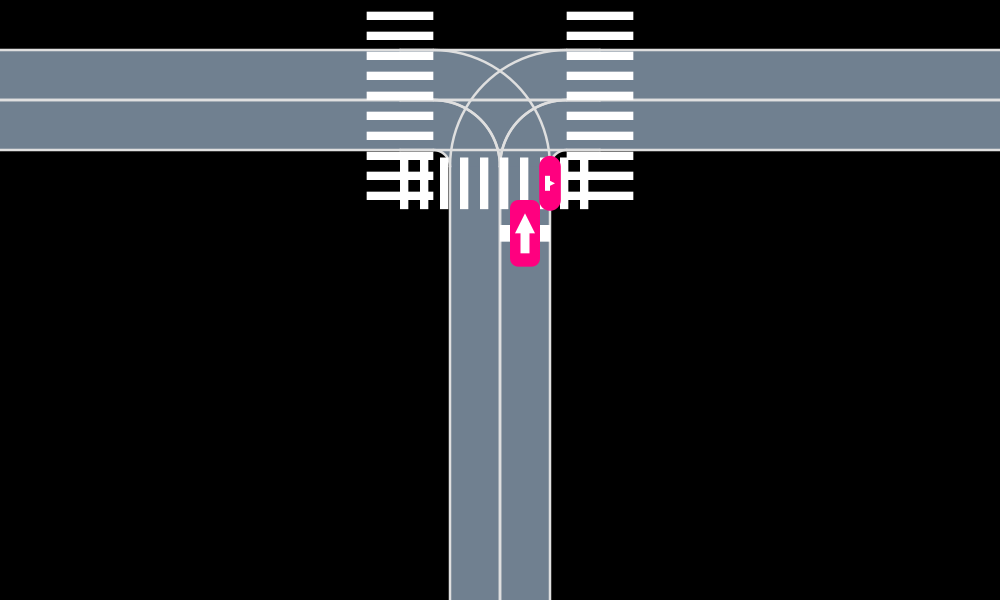

In [77]:
AutoViz.render(state2scene(mdp, states(mdp)[15273]), env, cam=FitToContentCamera(0.))

evaluation_loop (generic function with 2 methods)

1218.079457 seconds (15.70 G allocations: 425.871 GiB, 17.20% gc time)
Summary for 10000 episodes: 
Average reward: 0.016 
Average # of steps: 89.368 
Average # of violations: 0.260 


In [34]:
P = get_proba(mdp, result);

In [32]:
print_summary(rewards_mask, steps_mask, violations_mask)

Summary for 1000 episodes: 
Average reward: 0.010 
Average # of steps: 77.330 
Average # of violations: 14.400 


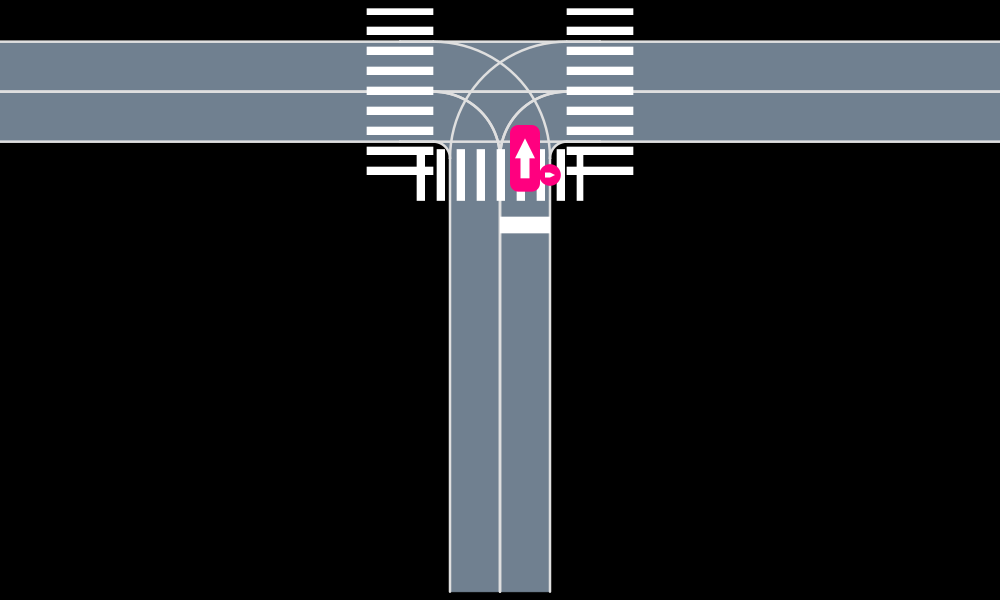

In [44]:
s = states(mdp)[2675]
AutoViz.render(state2scene(mdp, s), env, cam=FitToContentCamera(0.))

In [41]:
safe_actions(mask, s)

4-element Array{AutomotivePOMDPs.UrbanAction,1}:
 AutomotivePOMDPs.UrbanAction(-4.0)
 AutomotivePOMDPs.UrbanAction(-2.0)
 AutomotivePOMDPs.UrbanAction(0.0) 
 AutomotivePOMDPs.UrbanAction(2.0) 

In [38]:
sc_itp, sc_itpw = interpolate_state(mdp, sc)
for u in sc_itp
    println(u.ego)
end

VehicleState(VecSE2({1.500, -5.000}, 1.571), Frenet(RoadIndex({1, 0.961538}, {6, 1}), 25.000, 0.000, 0.000), 0.000)
VehicleState(VecSE2({1.500, -4.000}, 1.571), Frenet(RoadIndex({1, 1.000000}, {6, 1}), 26.000, 0.000, 0.000), 0.000)
VehicleState(VecSE2({1.500, -5.000}, 1.571), Frenet(RoadIndex({1, 0.961538}, {6, 1}), 25.000, 0.000, 0.000), 0.000)
VehicleState(VecSE2({1.500, -4.000}, 1.571), Frenet(RoadIndex({1, 1.000000}, {6, 1}), 26.000, 0.000, 0.000), 0.000)


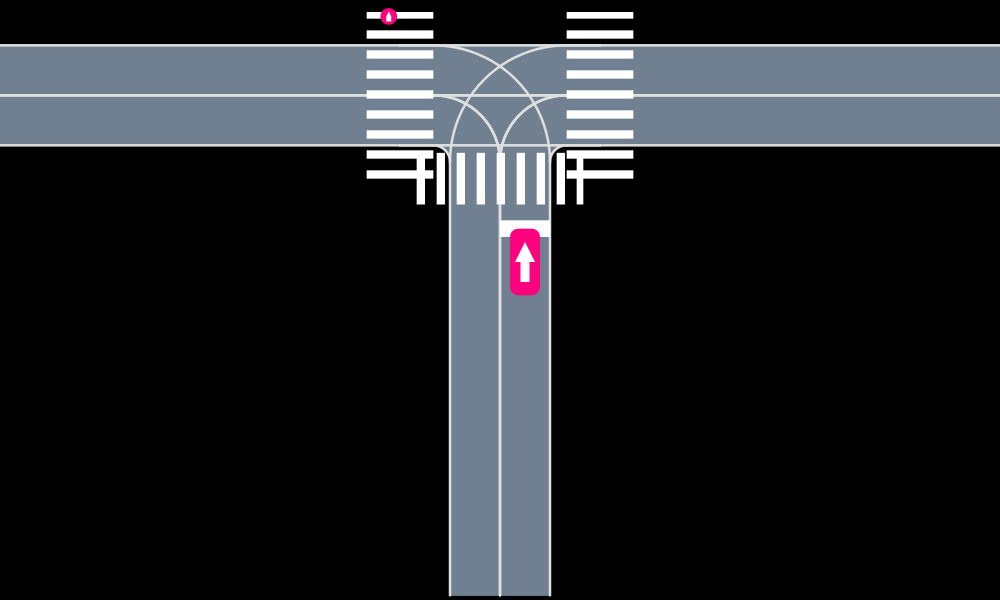

In [29]:
AutoViz.render(s0, env, cam=FitToContentCamera(0.))

In [88]:
AutomotivePOMDPs.n_pedestrians(s0)

0

In [19]:
sc = h.state_hist[end-1]
si = stateindex(mdp, sc)
mask.risk_vec[si]
a = UrbanAction(-2.)
ai = actionindex(mdp, a)
d = transition(mdp, sc, a)
psa = zeros(4)
for (sp, p) in weighted_iterator(d)
    spi = stateindex(mdp, sp)
    println(sp.crash, " ", spi, " ", p)
    println(sp)
    p == 0.0 ? continue : nothing # skip if zero prob
    psa[ai] += p * P[spi]
end
psa

LoadError: [91mUndefVarError: h not defined[39m

In [88]:
s0 = initialstate(mdp, rng)
s0.ego

VehicleState(VecSE2({1.500, -10.000}, 1.571), Frenet(RoadIndex({1, 0.769231}, {6, 1}), 20.000, 0.000, 0.000), 0.000)

In [83]:
sc.ego == states(mdp)[50].ego

false

In [84]:
sc == states(mdp)[50]

false

In [85]:
stateindex(mdp, sc)

50

In [86]:
stateindex(mdp, states(mdp)[50])

50

In [77]:
states(mdp)[40].ego

VehicleState(VecSE2({1.500, -30.000}, 1.571), Frenet(RoadIndex({1, 0.000000}, {6, 1}), 0.000, 0.000, 0.000), 0.000)

In [69]:
labels[]

LoadError: [91mKeyError: key PedMDPState(false, VehicleState(VecSE2({1.500, -30.000}, 1.571), Frenet(RoadIndex({1, 0.000000}, {6, 1}), 0.000, 0.000, 0.000), 0.000), VehicleState(VecSE2({-6.000, 1.000}, 1.571), Frenet(RoadIndex({1, 0.600000}, {18, 1}), 6.000, 0.000, 0.000), 0.000)) not found[39m

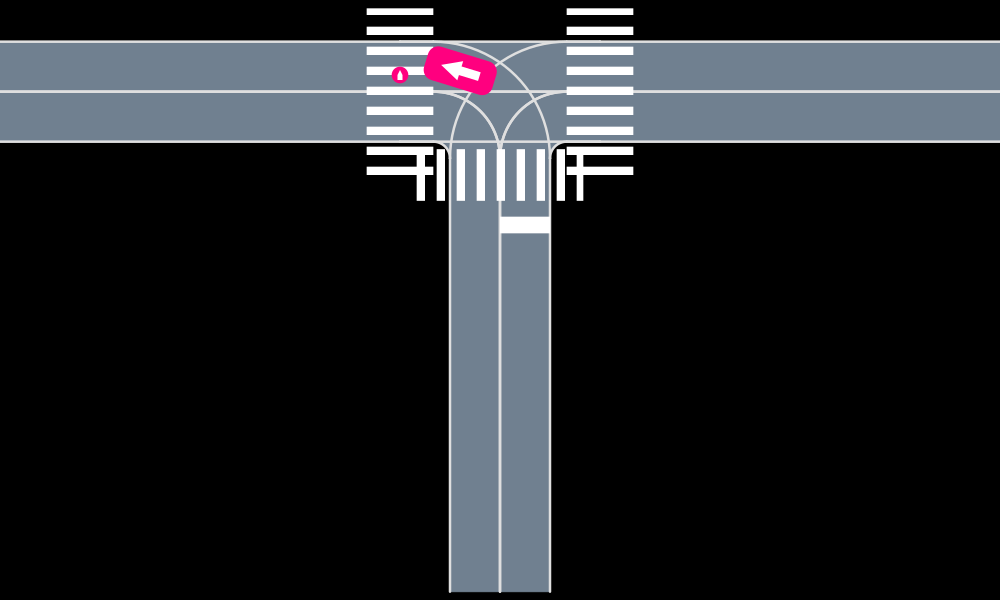

In [39]:
scene = state2scene(mdp, sc)
AutoViz.render(scene, env, cam=FitToContentCamera(0.))

In [45]:
rewards_vi, steps_vi, violations_vi = evaluation_loop(mdp, vi_policy, n_ep=1000, max_steps=100, rng=rng);
print_summary(rewards_vi, steps_vi, violations_vi)

Summary for 1000 episodes: 
Average reward: 0.444 
Average # of steps: 17.037 
Average # of violations: 0.015 


In [36]:
maximum(steps_vi)

74.0

In [37]:
maximum(steps_mask)

75.0

## Solve with Q learning

In [51]:
using TabularTDLearning

In [ ]:
solver = QLearningSolver(mdp, 
                         n_episodes=10000, 
                         learning_rate = 0.1, 
                         exp_policy = EpsGreedyPolicy(mdp, 0.9, rng=MersenneTwister(1)),
                         rng = MersenneTwister(1),
                         n_eval_traj = 100,
                         max_episode_length = 100,
                         log_eval = true)

ql_policy = solve(solver, mdp, verbose=false)
ql_training_perf = solver.r_log

On Iteration 10, Returns: 0.0
On Iteration 20, Returns: 0.0
On Iteration 30, Returns: 0.0
On Iteration 40, Returns: 0.0
On Iteration 50, Returns: 0.0
On Iteration 60, Returns: 0.0
On Iteration 70, Returns: 0.0
On Iteration 80, Returns: 0.0
On Iteration 90, Returns: 0.0
On Iteration 100, Returns: 0.0
On Iteration 110, Returns: 0.0
On Iteration 120, Returns: 0.0
On Iteration 130, Returns: 0.0
On Iteration 140, Returns: 0.0
On Iteration 150, Returns: 0.0
On Iteration 160, Returns: 0.0
On Iteration 170, Returns: 0.0
On Iteration 180, Returns: 0.0
On Iteration 190, Returns: 0.0
On Iteration 200, Returns: 0.0
On Iteration 210, Returns: 0.0
On Iteration 220, Returns: 0.0
On Iteration 230, Returns: 0.0
On Iteration 240, Returns: 0.0
On Iteration 250, Returns: 0.0
On Iteration 260, Returns: 0.0
On Iteration 270, Returns: 0.0
On Iteration 280, Returns: 0.0
On Iteration 290, Returns: 0.0


In [83]:
sim = RolloutSimulator(rng, 100)
s0 = initialstate(mdp, rng)
rtot = simulate(sim, mdp, ql_policy, s0)

0.0

### Discrete MDP with car

In [7]:
using Parameters, StaticArrays
include("mdp_models/discretization.jl")
include("mdp_models/interpolation.jl")
include("mdp_models/car_mdp/pomdp_types.jl")
include("mdp_models/car_mdp/state_space.jl")
include("mdp_models/car_mdp/transition.jl")
include("mdp_models/car_mdp/render_helpers.jl")

state2scene

In [8]:
mdp = CarMDP(env = env);
labels = labeling(mdp);

**Print some model information**

In [9]:
@printf("spatial resolution %2.1f m \n", mdp.pos_res)
@printf("car velocity resolution %2.1f m \n", mdp.vel_res)
@printf("number of states %d \n", n_states(mdp))
@printf("number of actions %d \n", n_actions(mdp))

spatial resolution 3.0 m 
car velocity resolution 2.0 m 
number of states 71946 
number of actions 4 


In [ ]:
property = "Pmax=? [ (!\"crash\") U \"goal\"]" 

In [ ]:
result = model_checking(mdp, labels, property, transition_file_name="carmdp.tra", labels_file_name="carmdp.lab");

In [10]:
solver = ValueIterationSolver(max_iterations=1000)
mdp.collision_cost = -1
vi_policy = solve(solver, mdp, verbose=true)

[Iteration 1   ] residual:          1 | iteration runtime: 217390.406 ms, (       217 s total)
[Iteration 2   ] residual:      0.944 | iteration runtime: 174219.120 ms, (       392 s total)
[Iteration 3   ] residual:      0.742 | iteration runtime: 176359.999 ms, (       568 s total)
[Iteration 4   ] residual:      0.516 | iteration runtime: 155502.755 ms, (       723 s total)
[Iteration 5   ] residual:       0.42 | iteration runtime: 173806.131 ms, (       897 s total)
[Iteration 6   ] residual:      0.367 | iteration runtime: 166680.977 ms, (  1.06E+03 s total)
[Iteration 7   ] residual:      0.309 | iteration runtime: 168317.011 ms, (  1.23E+03 s total)
[Iteration 8   ] residual:      0.271 | iteration runtime: 176425.677 ms, (  1.41E+03 s total)
[Iteration 9   ] residual:      0.202 | iteration runtime: 188212.833 ms, (  1.6E+03 s total)
[Iteration 10  ] residual:      0.182 | iteration runtime: 200350.472 ms, (  1.8E+03 s total)
[Iteration 11  ] residual:      0.158 | iteration ru

DiscreteValueIteration.ValueIterationPolicy([0.37787 0.37787 0.37787 0.399853; 0.376629 0.376629 0.376629 0.398214; … ; 1.0 1.0 1.0 1.0; 0.0 0.0 0.0 0.0], [0.399853, 0.398214, 0.397008, 0.396683, 0.397506, 0.399271, 0.40106, 0.400479, 0.387324, 0.387682  …  0.0, 0.807699, 0.842593, 0.873786, 0.895255, 0.928514, 0.947031, 0.9875, 1.0, 0.0], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  1, 4, 4, 4, 4, 4, 4, 4, 1, 1], AutomotivePOMDPs.UrbanAction[AutomotivePOMDPs.UrbanAction(-4.0), AutomotivePOMDPs.UrbanAction(-2.0), AutomotivePOMDPs.UrbanAction(0.0), AutomotivePOMDPs.UrbanAction(2.0)], true, CarMDP
  env: AutomotivePOMDPs.UrbanEnv
  ego_type: AutomotiveDrivingModels.VehicleDef
  car_type: AutomotiveDrivingModels.VehicleDef
  car_model: AutomotivePOMDPs.RouteFollowingIDM
  max_acc: Float64 2.0
  pos_res: Float64 3.0
  vel_res: Float64 2.0
  ego_start: Float64 20.0
  ego_goal: AutomotiveDrivingModels.LaneTag
  off_grid: Vec.VecSE2{Float64}
  ΔT: Float64 0.5
  car_birth: Float64 0.3
  collision_cost: F

In [11]:
# using JLD

In [12]:
# JLD.save("carmdp_policy.jld", "policy", vi_policy)

In [13]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(mdp, rng)
@time hist = simulate(hr, mdp, vi_policy, s0);

LoadError: [91mtype CarMDP has no field vel_car_res[39m

In [ ]:
function animate_states(mdp::PedMDP, states::Vector{PedMDPState}, actions::Vector{PedMDPAction};
                        overlays=SceneOverlay[IDOverlay()],
                        cam=StaticCamera(VecE2(0, -5.), 17.))
    duration = length(states)*mdp.ΔT
    fps = Int(1/pomdp.ΔT)    
    function render_states(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        scene = state2scene(mdp, states[frame_index])
        return AutoViz.render(scene,
                              pomdp.env,
                              cat(1, overlays, TextOverlay(text = ["Acc: $(actions[frame_index].acc)"],
                                                           font_size=20,
                                                           pos=VecE2(0.,8.),
                                                           incameraframe=true)),
                              cam=cam,
                              car_colors=get_colors(scene))
    end
    return duration, fps, render_states
end

In [ ]:
state_hist = hist.state_hist
action_hist = hist.action_hist
push!(action_hist, PedMDPAction(0.))
duration, fps, render_hist = animate_states(mdp, state_hist, action_hist)
film = roll(render_hist, fps = fps, duration = duration)

In [123]:
@time state_space = states(mdp);
@time action_space = actions(mdp);

  0.759735 seconds (5.51 M allocations: 150.967 MiB, 13.38% gc time)
  0.005958 seconds (420 allocations: 25.019 KiB)


In [124]:
@time car_states, start_routes = car_starting_states(mdp);

  0.059528 seconds (10.97 k allocations: 507.617 KiB)


In [125]:
for route in start_routes
    if isempty(route)
        println("bug")
    end
end

In [126]:
n_states(mdp)

71946

In [127]:
routes = get_car_routes(mdp.env)
typeof(routes)

StaticArrays.SArray{Tuple{4},StaticArrays.SArray{S,AutomotiveDrivingModels.Lane,1,L} where L where S<:Tuple,1,4}

In [128]:
@showprogress for s in ordered_states(mdp)
    for a in ordered_actions(mdp)
#         println("state index ", stateindex(mdp, s), " action index ", actionindex(mdp, a))
        d = transition(mdp, s, a)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


In [239]:
routes = get_car_routes(env)
car_states = get_car_states(mdp.env, routes[1], mdp.pos_res, mdp.vel_res);

In [234]:
function test_car_indexing(env::UrbanEnv, pos_res::Float64, vel_res::Float64)
    for route in routes
        car_states = get_car_states(env, route, pos_res, vel_res)
        for (i, car) in enumerate(car_states) 
            car_i = car_stateindex(env, car, route, pos_res, vel_res)
            if car_i != i
                return false 
            end
        end
        @assert n_car_states(env, route, pos_res, vel_res) == length(car_states)
    end
    return true
end
    
# car = car_states[1]
# route = routes[1]
# car_i = car_stateindex(mdp.env, car, route, mdp.pos_res, mdp.vel_res)

test_car_indexing (generic function with 1 method)

In [235]:
test_car_indexing(mdp.env, mdp.pos_res, mdp.vel_res)

true

In [176]:
@time n_states(mdp)

  0.000027 seconds (19 allocations: 1.453 KiB)


46998

In [183]:
routes = get_car_routes(env)

false

In [171]:
for lane in get_car_lanes(env)
    routes =  get_possible_routes(env.roadway[lane], env)
    println(routes)
end

[1, 2]
[1]
[3, 4]
[3]
[2, 4]
[1]
[3]
[1, 2]
[2, 3]
[3, 4]
[4]


In [172]:
get_car_lanes(env)

11-element Array{AutomotiveDrivingModels.LaneTag,1}:
 LaneTag(1, 1) 
 LaneTag(2, 1) 
 LaneTag(3, 1) 
 LaneTag(4, 1) 
 LaneTag(5, 1) 
 LaneTag(7, 1) 
 LaneTag(8, 1) 
 LaneTag(9, 1) 
 LaneTag(10, 1)
 LaneTag(11, 1)
 LaneTag(12, 1)

In [145]:
car_states = get_car_states(env, mdp.pos_res, mdp.vel_res)
for car in car_states 
    routes = get_possible_routes(get)

402-element Array{AutomotiveDrivingModels.VehicleState,1}:
 VehicleState(VecSE2({30.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.000000}, {1, 1}), 0.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({27.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.125000}, {1, 1}), 3.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({24.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.250000}, {1, 1}), 6.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({21.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.375000}, {1, 1}), 9.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({18.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.500000}, {1, 1}), 12.000, 0.000, 0.000), 0.000) 
 VehicleState(VecSE2({15.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.625000}, {1, 1}), 15.000, 0.000, 0.000), 0.000) 
 VehicleState(VecSE2({12.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.750000}, {1, 1}), 18.000, 0.000, 0.000), 0.000) 
 VehicleState(VecSE2({9.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.875000}, {1, 1}), 21.000, 0.000, 0.000), 0.000)

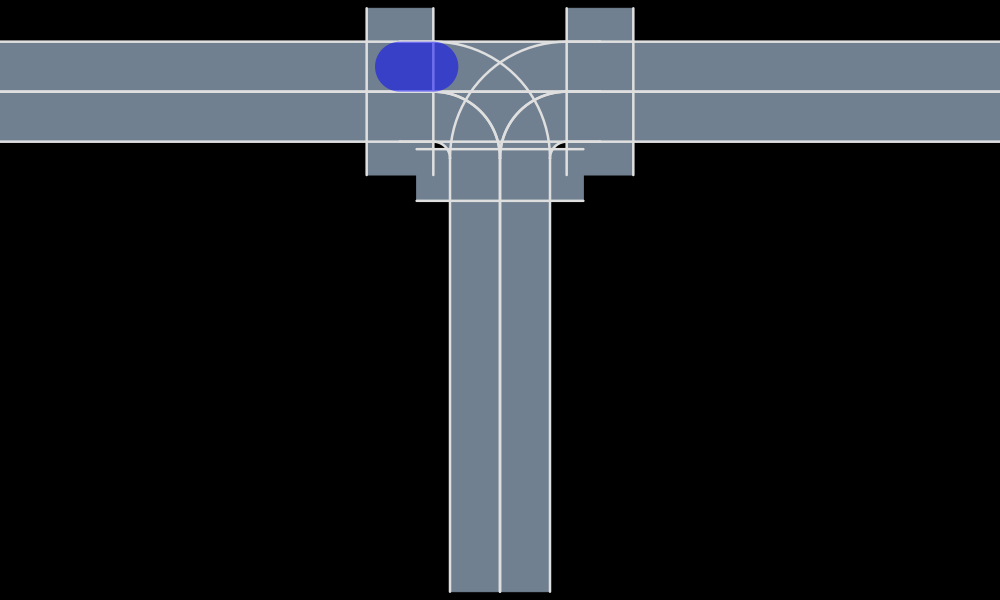

In [89]:
scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

i=14
render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))

In [17]:
function test_stateindexing(mdp::CarMDP)
    state_space = states(mdp)
    for (i, s) in enumerate(state_space)
        if i != stateindex(mdp, s)
            return false
        end
    end
    return true
end

test_stateindexing (generic function with 1 method)

In [19]:
function evaluation_loop(mdp::MDP, policy::Policy; n_ep::Int64 = 100, max_steps::Int64 = 200, rng::AbstractRNG = Base.GLOBAL_RNG)
    hr = HistoryRecorder(max_steps=max_steps, rng=rng)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    for ep=1:n_ep
        s0 = initialstate(mdp, rng)
        hist = simulate(hr, mdp, policy, s0)
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
    end
    return rewards, steps
end

evaluation_loop (generic function with 1 method)

In [24]:
n_ep = 1000
rewards, steps = evaluation_loop(mdp, vi_policy, n_ep=n_ep)

([0.5688, 0.54036, 0.440127, -0.814506, 0.41812, 0.487675, 0.214639, 0.513342, 0.250344, 0.487675  …  0.54036, 0.27739, 0.54036, 0.598737, 0.0730977, 0.5688, 0.54036, 0.0305636, 0.513342, 0.440127], [12.0, 13.0, 17.0, 5.0, 18.0, 15.0, 31.0, 14.0, 28.0, 15.0  …  13.0, 26.0, 13.0, 11.0, 52.0, 12.0, 13.0, 69.0, 14.0, 17.0])

In [28]:
avg_reward = mean(rewards)
avg_steps = mean(steps)
avg_crash = sum(rewards .< 0.)/n_ep*100

0.8999999999999999

## Solve using Value Iteration

In [20]:
solver = ValueIterationSolver(max_iterations=1000)
vi_policy = solve(solver, mdp, verbose=true)

LoadError: [91mUndefRefError: access to undefined reference[39m

In [78]:
function random_ego_interpolation(rng::AbstractRNG)
    lanes = get_ego_route(mdp.env)
    lane = lanes[rand(rng, 1:length(lanes))]
    s = rand(rng, 0:0.1:get_end(mdp.env.roadway[lane]))
    v = rand(rng, 0:0.1:mdp.env.params.speed_limit)
    ego_state = VehicleState(Frenet(mdp.env.roadway[lane], s), mdp.env.roadway, v)
    states, probs = interpolate_state(ego_state, get_car_vspace(mdp.env, mdp.vel_res))
    scene = Scene()
    for (i, itp_state) in enumerate(states)
        push!(scene, Vehicle(itp_state, mdp.ego_type, i+1))
    end
    push!(scene, Vehicle(ego_state, mdp.ego_type, 1))
    render(scene, env, cam=FitToContentCamera(0.), car_colors=get_colors(scene))
end

function random_ped_interpolation(rng::AbstractRNG)
    lanes = get_ped_lanes(mdp.env)
    lane = lanes[rand(rng, 1:length(lanes))]
    s = rand(rng, 0:0.1:get_end(mdp.env.roadway[lane]))
    v = rand(rng, 0:0.1:2.0)
    ped_state = VehicleState(Frenet(mdp.env.roadway[lane], s), mdp.env.roadway, v)
    states, probs = interpolate_state(ped_state, get_car_vspace(mdp.env, mdp.vel_res))
    scene = Scene()
    for (i, itp_state) in enumerate(states)
        push!(scene, Vehicle(itp_state, mdp.ped_type, i+1))
    end
    push!(scene, Vehicle(ped_state, mdp.ped_type, 1))
    render(scene, env, cam=FitToContentCamera(0.), car_colors=get_colors(scene))
end


function random_car_interpolation(rng::AbstractRNG)
    lanes = get_car_lanes(mdp.env)
    lane = lanes[rand(rng, 1:length(lanes))]
    s = rand(rng, 0:0.1:get_end(mdp.env.roadway[lane]))
    v = rand(rng, 0:0.1:2.0)
    car_state = VehicleState(Frenet(mdp.env.roadway[lane], s), mdp.env.roadway, v)
    states, probs = interpolate_state(car_state, get_car_vspace(mdp.env, mdp.vel_res))
    scene = Scene()
    for (i, itp_state) in enumerate(states)
        push!(scene, Vehicle(itp_state, VehicleDef(), i+1))
    end
    push!(scene, Vehicle(car_state, VehicleDef(), 1))
    render(scene, env, cam=FitToContentCamera(0.), car_colors=get_colors(scene))
end

random_car_interpolation (generic function with 1 method)

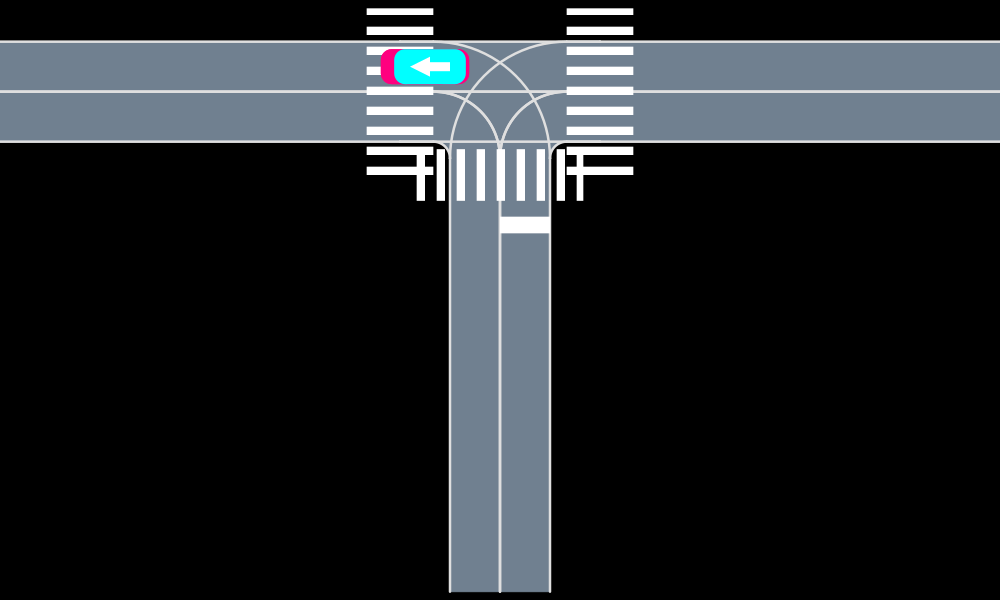

In [83]:
random_car_interpolation(rng)

In [27]:
function test_ego_interpolation(mdp::PedMDP)
    ego_state_space = get_ego_states(mdp.env, mdp.pos_res, mdp.vel_res)
    v_space = get_car_vspace(mdp.env, mdp.vel_res)
    for s in ego_state_space
        states, weights = interpolate_state(s, v_space)
        if !(length(states) == 1 &&
             weights[1] == 1.0 &&
             states[1] ∈ ego_state_space)
            return false 
        end
    end
    return true
end

function test_car_interpolation(mdp::PedMDP)
    car_state_space = get_car_states(mdp.env, mdp.pos_res, mdp.vel_res)
    v_space = get_car_vspace(mdp.env, mdp.vel_res)
    for s in car_state_space
        states, weights = interpolate_state(s, v_space)
        if !(length(states) == 1 &&
             weights[1] == 1.0 &&
             states[1] ∈ car_state_space)
            return false 
        end
    end
    return true
end


function test_ped_interpolation(mdp::PedMDP)
    ped_state_space = get_ped_states(mdp.env, mdp.pos_res, mdp.vel_ped_res)
    v_space = get_ped_vspace(mdp.env, mdp.vel_ped_res)
    for s in ped_state_space
        states, weights = interpolate_state(s, v_space)
        if !(length(states) == 1 &&
             weights[1] == 1.0 &&
             states[1] ∈ ped_state_space)
            return false 
        end
    end
    return true
end



test_ped_interpolation (generic function with 1 method)

In [28]:
test_ego_interpolation(mdp)

true

In [29]:
test_ped_interpolation(mdp)

true

In [30]:
test_car_interpolation(mdp)

true

In [ ]:
function test_stateindexing(mdp::PedMDP)
    state_space = states(mdp)
    for (i, s) in enumerate(state_space)
        if i != stateindex(mdp, s)
            println(i)
            println(s)
            return false
        end
    end
    return true
end

In [9]:
test_stateindexing(mdp)

true

In [12]:
state_space

36600

In [13]:
n_ped_states(mdp.env, mdp.pos_res, mdp.vel_ped_res)

99

In [14]:
n_ego_states(mdp.env, mdp.pos_res, mdp.vel_res)

366

In [11]:
s = states(mdp)[36601]
ego_i = ego_stateindex(mdp.env, s.ego, mdp.pos_res, mdp.vel_res)
ped_i = ped_stateindex(mdp.env, s.ped, mdp.pos_res, mdp.vel_ped_res)

26

In [17]:
s.ego

VehicleState(VecSE2({1.500, -30.000}, 1.571), Frenet(RoadIndex({1, 0.000000}, {6, 1}), 0.000, 0.000, 0.000), 0.000)

In [13]:
function test_ego_space(mdp::PedMDP)
    ego_space = get_ego_states(mdp.env, mdp.pos_res, mdp.vel_res);
    for (i, s) in enumerate(ego_space)
        if i != ego_stateindex(env, s, mdp.pos_res, mdp.vel_res)
            return false
        end
    end
    return true
end

function test_car_space(mdp::PedMDP)
    car_space = get_car_states(mdp.env, mdp.pos_res, mdp.vel_res);
    for (i, s) in enumerate(car_space)
        if i != car_stateindex(env, s, mdp.pos_res, mdp.vel_res)
            return false
        end
    end
    return true
end

function test_ped_space(mdp::PedMDP)
    ped_space = get_ped_states(mdp.env, mdp.pos_res, mdp.vel_res);
    for (i, s) in enumerate(ped_space)
        if i != ped_stateindex(env, s, mdp.pos_res, mdp.vel_res)
            return false
        end
    end
    return true
end


test_ped_space (generic function with 1 method)

In [14]:
test_ego_space(mdp)

true

In [15]:
test_car_space(mdp)

true

In [16]:
test_ped_space(mdp)

true

In [17]:
using Traceur

In [18]:
@trace get_ego_states(mdp.env, mdp.pos_res, mdp.vel_res)

(Vec.lerp)(::AutomotiveDrivingModels.CurvePt, ::AutomotiveDrivingModels.CurvePt, ::Float64) at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/curves.jl:12
  dynamic dispatch to (AutomotiveDrivingModels.lerp)((Core.getfield)(a, :pos), (Core.getfield)(b, :pos), t) at line 12
  dynamic dispatch to (AutomotiveDrivingModels.CurvePt)((AutomotiveDrivingModels.lerp)((Core.getfield)(a, :pos), (Core.getfield)(b, :pos), t), (Base.add_float)((Core.getfield)(a, :s), (Base.mul_float)((Base.sub_float)((Core.getfield)(b, :s), (Core.getfield)(a, :s)), t)), (Base.add_float)((Core.getfield)(a, :k), (Base.mul_float)((Base.sub_float)((Core.getfield)(b, :k), (Core.getfield)(a, :k)), t)), (Base.add_float)((Core.getfield)(a, :kd), (Base.mul_float)((Base.sub_float)((Core.getfield)(b, :kd), (Core.getfield)(a, :kd)), t))) at line 12
(getindex)(::Array{AutomotiveDrivingModels.CurvePt,1}, ::AutomotiveDrivingModels.CurveIndex) at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModel

  dynamic dispatch to (Core.getfield)(frenet, :ϕ) + (Core.getfield)((Core.getfield)(curvept, :pos), :θ) at line 29
  dynamic dispatch to (AutomotiveDrivingModels.VecSE2)((Core.getfield)(pos, :x), (Core.getfield)(pos, :y), (Core.getfield)(frenet, :ϕ) + (Core.getfield)((Core.getfield)(curvept, :pos), :θ)) at line 29
  returns Any
(AutomotiveDrivingModels.VehicleState)(::AutomotiveDrivingModels.Frenet, ::AutomotiveDrivingModels.Roadway, ::Float64) at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/vehicles/vehicles.jl:11
  dynamic dispatch to (Base.convert)(AutomotiveDrivingModels.VecSE2, $(Expr(:invoke, MethodInstance for get_posG(::AutomotiveDrivingModels.Frenet, ::AutomotiveDrivingModels.Roadway), :(AutomotiveDrivingModels.get_posG), :posF, :roadway))) at line 11
(get_ego_states)(::AutomotivePOMDPs.UrbanEnv, ::Float64, ::Float64) at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/safe-rl/mdp_models/discretization.jl:25
  dynamic dispatch to 

366-element Array{AutomotiveDrivingModels.VehicleState,1}:
 VehicleState(VecSE2({1.500, -30.000}, 1.571), Frenet(RoadIndex({1, 0.000000}, {6, 1}), 0.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -29.000}, 1.571), Frenet(RoadIndex({1, 0.038462}, {6, 1}), 1.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -28.000}, 1.571), Frenet(RoadIndex({1, 0.076923}, {6, 1}), 2.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -27.000}, 1.571), Frenet(RoadIndex({1, 0.115385}, {6, 1}), 3.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -26.000}, 1.571), Frenet(RoadIndex({1, 0.153846}, {6, 1}), 4.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -25.000}, 1.571), Frenet(RoadIndex({1, 0.192308}, {6, 1}), 5.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -24.000}, 1.571), Frenet(RoadIndex({1, 0.230769}, {6, 1}), 6.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({1.500, -23.000}, 1.571), Frenet(RoadIndex({1, 0.269231}, {6, 1}), 7.000, 0.000, 0.000)

In [21]:
@trace get_car_states(mdp.env, mdp.pos_res, mdp.vel_res)

(Vec.lerp)(::AutomotiveDrivingModels.CurvePt, ::AutomotiveDrivingModels.CurvePt, ::Float64) at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModels/src/2d/roadway/curves.jl:12
  dynamic dispatch to (AutomotiveDrivingModels.lerp)((Core.getfield)(a, :pos), (Core.getfield)(b, :pos), t) at line 12
  dynamic dispatch to (AutomotiveDrivingModels.CurvePt)((AutomotiveDrivingModels.lerp)((Core.getfield)(a, :pos), (Core.getfield)(b, :pos), t), (Base.add_float)((Core.getfield)(a, :s), (Base.mul_float)((Base.sub_float)((Core.getfield)(b, :s), (Core.getfield)(a, :s)), t)), (Base.add_float)((Core.getfield)(a, :k), (Base.mul_float)((Base.sub_float)((Core.getfield)(b, :k), (Core.getfield)(a, :k)), t)), (Base.add_float)((Core.getfield)(a, :kd), (Base.mul_float)((Base.sub_float)((Core.getfield)(b, :kd), (Core.getfield)(a, :kd)), t))) at line 12
(getindex)(::Array{AutomotiveDrivingModels.CurvePt,1}, ::AutomotiveDrivingModels.CurveIndex) at /mnt/c/Users/Maxime/wsl/.julia/v0.6/AutomotiveDrivingModel

(get_car_states)(::AutomotivePOMDPs.UrbanEnv, ::Float64, ::Float64) at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/safe-rl/mdp_models/discretization.jl:73
  dynamic dispatch to (Base.convert)(AutomotiveDrivingModels.VecSE2, $(Expr(:invoke, MethodInstance for get_posG(::AutomotiveDrivingModels.Frenet, ::AutomotiveDrivingModels.Roadway), :(AutomotiveDrivingModels.get_posG), :($(Expr(:new, :(AutomotiveDrivingModels.Frenet), :roadind, :s, 0.0, 0.0))), :((Core.getfield)(env, :roadway))))) at line 79


954-element Array{AutomotiveDrivingModels.VehicleState,1}:
 VehicleState(VecSE2({30.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.000000}, {1, 1}), 0.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({29.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.041667}, {1, 1}), 1.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({28.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.083333}, {1, 1}), 2.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({27.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.125000}, {1, 1}), 3.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({26.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.166667}, {1, 1}), 4.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({25.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.208333}, {1, 1}), 5.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({24.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.250000}, {1, 1}), 6.000, 0.000, 0.000), 0.000)  
 VehicleState(VecSE2({23.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.291667}, {1, 1}), 7.000, 0.000, 0.000), 0.000)

In [23]:
c = get_car_states(mdp.env, mdp.pos_res, mdp.vel_res)[123]
@trace car_stateindex(mdp.env, c, mdp.pos_res, mdp.vel_res)

123

In [9]:
ego = ego_space[163]

VehicleState(VecSE2({1.500, -4.000}, 1.571), Frenet(RoadIndex({1, 0.000000}, {13, 1}), 0.000, 0.000, 0.000), 0.000)

In [10]:
ego_stateindex(mdp.env, ego_space[163], mdp.pos_res, mdp.vel_res)

163

In [11]:
lanes = get_ego_route(env)
lane = get_lane(env.roadway, ego)
li = findfirst(lanes, lane.tag) #XXX possibly inefficient

s_space = get_discretized_lane(lane.tag, mdp.env.roadway, mdp.pos_res)
si = find_range_index(s_space, ego.posF.s)

v_space = get_car_vspace(mdp.env, mdp.vel_res)
v = ego.v
vi = find_range_index(v_space, v)
egoi = sub2ind((length(s_space), length(v_space)), si, vi)

for i=2:li
    size_s = length(get_discretized_lane(lanes[i-1], env.roadway, pos_res))
    egoi += size_s*size_v
end

LoadError: [91mUndefVarError: pos_res not defined[39m

In [12]:
function ego_stateindex(env::UrbanEnv, ego::VehicleState, pos_res::Float64, v_res::Float64)
    # find lane index
    lanes = get_ego_route(env)
    lane = get_lane(env.roadway, ego)
    li = findfirst(lanes, lane.tag) #XXX possibly inefficient
    # find position index
    s_space = get_discretized_lane(lane.tag, env.roadway, pos_res)
    si = find_range_index(s_space, ego.posF.s)
    # find velocity index
    v_space = get_car_vspace(env, v_res)
    size_v = length(v_space)
    v = ego.v
    vi = find_range_index(v_space, v)
    # sub2ind magic
    egoi = sub2ind((length(s_space), length(v_space)), si, vi)
    # Lanes have different lengths
    for i=2:li
        size_s = length(get_discretized_lane(lanes[i], env.roadway, pos_res))
        egoi += size_s*size_v
    end
    return egoi
end

ego_stateindex (generic function with 1 method)

## Discrete Fully Observable Abstraction

In [13]:
using Parameters

In [14]:
typeof(pomdp.ego_type)

AutomotiveDrivingModels.VehicleDef

In [15]:
fieldnames(pomdp)

26-element Array{Symbol,1}:
 :env           
 :obs_dist      
 :lidar         
 :sensor        
 :models        
 :ego_type      
 :car_type      
 :ped_type      
 :max_cars      
 :max_peds      
 :obstacles     
 :max_acc       
 :ego_start     
 :ego_goal      
 :off_grid      
 :ΔT            
 :car_birth     
 :ped_birth     
 :a_noise       
 :v_noise       
 :pos_obs_noise 
 :vel_obs_noise 
 :collision_cost
 :action_cost   
 :goal_reward   
 :γ             

In [16]:
struct PedestrianMDP
    env::UrbanEnv
    
end

In [17]:
# discretize velocity levels:
function get_car_vspace(pomdp::UrbanPOMDP, v_res::Float64)
    return 0.:v_res:pomdp.env.params.speed_limit
end

function get_ped_vspace(pomdp::UrbanPOMDP, v_res::Float64)
    return 0:v_res:2.0
end

# discretize longitudinal position
function get_discretized_lane(tag::LaneTag, roadway::Roadway, pos_res::Float64)
    lane = roadway[tag]
    return 0.:pos_res:get_end(lane)
end

# struct DiscreteUrbanState
#     ego::VehicleState
#     car::VehicleState
#     ped::VehicleState
# end

# enumerate ego state space
function get_ego_route(pomdp::UrbanPOMDP)
    return [LaneTag(6,1), LaneTag(13, 1), LaneTag(2,1)]
end

function get_ego_states(pomdp::UrbanPOMDP, pos_res::Float64, v_res::Float64)
    states_vec = VehicleState[]
    for lane in get_ego_route(pomdp)
        discrete_lane = get_discretized_lane(lane, pomdp.env.roadway, pos_res)
        v_space = get_car_vspace(pomdp, v_res)
        for v in v_space
            for s in discrete_lane
                ego = VehicleState(Frenet(pomdp.env.roadway[lane], s), pomdp.env.roadway, v)
                push!(states_vec, ego)
            end
        end
    end
    return states_vec
end

# enumerate pedestrian state space
function get_ped_lanes(pomdp::UrbanPOMDP)
    return [LaneTag(17, 1), LaneTag(18, 1), LaneTag(19, 1)]
end

function get_ped_states(pomdp::UrbanPOMDP, pos_res::Float64, v_res::Float64)
    states_vec = VehicleState[]
    for lane in get_ped_lanes(pomdp::UrbanPOMDP)
        discrete_lane = get_discretized_lane(lane, pomdp.env.roadway, pos_res)
        v_space = get_ped_vspace(pomdp, v_res)
        for v in v_space
            for s in discrete_lane
                ped = VehicleState(Frenet(pomdp.env.roadway[lane], s), pomdp.env.roadway, v)
                push!(states_vec, ped)
            end
        end
    end
    return states_vec
end

# enumerate other car state space 
function get_car_lanes(pomdp::UrbanPOMDP)
    lanes = get_lanes(pomdp.env.roadway)
    car_lanes = LaneTag[]
    for lane in lanes
        if !(lane.tag ∈ get_ego_route(pomdp)) && !(lane.tag ∈ get_ped_lanes(pomdp))
            push!(car_lanes, lane.tag)
        end
    end
    return car_lanes
end

function get_car_states(pomdp::UrbanPOMDP, pos_res::Float64, v_res::Float64)
    states_vec = VehicleState[]
    for lane in get_car_lanes(pomdp::UrbanPOMDP)
        discrete_lane = get_discretized_lane(lane, pomdp.env.roadway, pos_res)
        v_space = get_car_vspace(pomdp, v_res)
        for v in v_space
            for s in discrete_lane
                car = VehicleState(Frenet(pomdp.env.roadway[lane], s), pomdp.env.roadway, v)
                push!(states_vec, car)
            end
        end
    end
    return states_vec
end
            


# count state space
function n_ego_states(pomdp::UrbanPOMDP, pos_res::Float64, v_res::Float64)
    N = 0
    nv = length(get_car_vspace(pomdp, v_res))
    for lane in get_ego_route(pomdp)
        N += nv * length(get_discretized_lane(lane, pomdp.env.roadway, pos_res))
    end
    return N
end

function n_ped_states(pomdp::UrbanPOMDP, pos_res::Float64, v_res::Float64)
    N = 0
    nv = length(get_ped_vspace(pomdp, v_res))
    for lane in get_ped_lanes(pomdp)
        N += nv * length(get_discretized_lane(lane, pomdp.env.roadway, pos_res))
    end
    return N
end

function n_car_states(pomdp::UrbanPOMDP, pos_res::Float64, v_res::Float64)
    N = 0
    nv = length(get_car_vspace(pomdp, v_res))
    for lane in get_car_lanes(pomdp)
        N += nv * length(get_discretized_lane(lane, pomdp.env.roadway, pos_res))
    end
    return N
end

function n_states(pomdp::UrbanPOMDP)
    n_ego = n_ego_states(pomdp, pos_res, v_res)
    n_car = n_car_states(pomdp, pos_res, v_res)
    n_ped = n_ped_states(pomdp, pos_res, v_ped_res)
    return n_ego*n_car*n_ped
end

# state indexing!


# transition as SparseCat?
# ego transition is known
# crash states are terminal
# goal states are terminal
        

n_states (generic function with 1 method)

In [18]:
# enumerate full state space
struct ExplicitUrbanState
    ego::VehicleState
    car::VehicleState
    ped::VehicleState
end

function POMDPs.states(pomdp::UrbanPOMDP)
    state_space = ExplicitUrbanState[]
    sizehint!(state_space, n_states(pomdp))
    for ego in get_ego_states(pomdp, pos_res, v_res)
    
end


LoadError: [91msyntax: incomplete: "function" at In[18]:8 requires end[39m

In [19]:
n_ego_states(pomdp, pos_res, v_res)

LoadError: [91mUndefVarError: pos_res not defined[39m

In [20]:
pos_res = 3.0
v_res = 2.0
v_ped_res = 1.0
ego_states = get_ego_states(pomdp, pos_res,  v_res);
ped_states = get_ped_states(pomdp, pos_res, v_ped_res);
car_states = get_car_states(pomdp, pos_res, v_res)

@assert length(ego_states) == n_ego_states(pomdp, pos_res, v_res)
@assert length(car_states) == n_car_states(pomdp, pos_res, v_res)
@assert length(ped_states) == n_ped_states(pomdp, pos_res, v_ped_res)
@assert length(states(pomdp)) == n_states(pomdp)

println("# of ego car states: $(length(ego_states))")
println("# of pedestrian states: $(length(ped_states))")
println("# of other car states: $(length(car_states))")
println("size of the states space $(length(ego_states)*length(ped_states)*length(car_states))")

LoadError: [91mMethodError: no method matching states(::AutomotivePOMDPs.UrbanPOMDP)[0m
Closest candidates are:
  states(::Union{POMDPs.MDP, POMDPs.POMDP}, [91m::Any[39m) at /mnt/c/Users/Maxime/wsl/.julia/v0.6/POMDPs/src/space.jl:26
  states([91m::PedMDP[39m) at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/safe-rl/mdp_models/pedestrian_mdp/state_space.jl:12
  states([91m::AutomotivePOMDPs.SingleOIPOMDP[39m) at /mnt/c/Users/Maxime/OneDrive - Leland Stanford Junior University/Research/AutomotivePOMDPs/single_intersection/spaces.jl:4
  ...[39m

In [21]:
l_space = get_discretized_lane(LaneTag(2,1), env.roadway, 3.0)

0.0:3.0:24.0

In [22]:
fieldnames(Lane)

8-element Array{Symbol,1}:
 :tag           
 :curve         
 :width         
 :speed_limit   
 :boundary_left 
 :boundary_right
 :exits         
 :entrances     

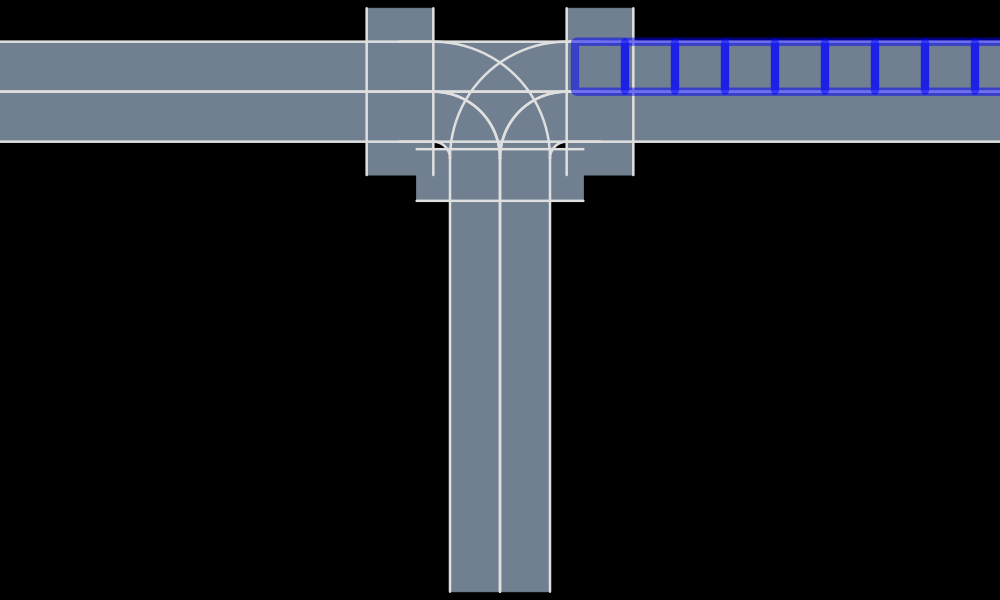

In [23]:
type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

@with_kw struct DiscreteLaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant = RGBA(0.0,0.0,1.0,0.5)
    pos_res::Float64 = 3.0
end

function render_grid_cell(    
    ctx           :: CairoContext,
    x             :: Real,
    y             :: Real,
    theta         :: Real,
    width         :: Real,
    height        :: Real,
    color_fill    :: Colorant,
    aspect        :: Real = 1.0,
    corner_radius :: Real = 0.1,
    color_stroke  :: Colorant    = color_fill,
    line_width    :: Real        = 0.5)
    save(ctx)

    translate(ctx, x, y)
    rotate(ctx, theta)

    render_round_rect(ctx, 0, 0, height, width, aspect, corner_radius, color_fill, false, true, color_stroke, line_width)
    restore(ctx)
end

function AutoViz.render!(rendermodel::RenderModel, overlay::DiscreteLaneOverlay, scene::Scene, roadway::Roadway)
    discrete_lane = get_discretized_lane(overlay.lane.tag, roadway, overlay.pos_res)
    for s in discrete_lane
        posF = Frenet(overlay.lane, s)
        posG = get_posG(posF, roadway)
        add_instruction!(rendermodel, 
                         render_grid_cell, 
                         (posG.x, posG.y, posG.θ, overlay.pos_res,overlay.lane.width, overlay.color),
                         incameraframe=true) 
    end
    return rendermodel
end

@with_kw struct GridOverlay <: SceneOverlay
    color::Colorant = RGBA(0.0,0.0,1.0,0.5)
    pos_res::Float64 = 3.0
end

function AutoViz.render!(rendermodel::RenderModel, overlay::GridOverlay, scene::Scene, roadway::Roadway)
    lanes = get_lanes(roadway)
    
    for lane in lanes
        discrete_lane_overlay = DiscreteLaneOverlay(lane, overlay.color, overlay.pos_res)
        AutoViz.render!(rendermodel, discrete_lane_overlay, scene, roadway)
    end
    return rendermodel
end


render(Scene(), env.roadway, [DiscreteLaneOverlay(lane=env.roadway[LaneTag(1,1)]),
                              DiscreteLaneOverlay(lane=env.roadway[LaneTag(6,1)]) ], cam=FitToContentCamera(0.))
# render(Scene(), env.roadway, [GridOverlay()], cam=FitToContentCamera(0.))

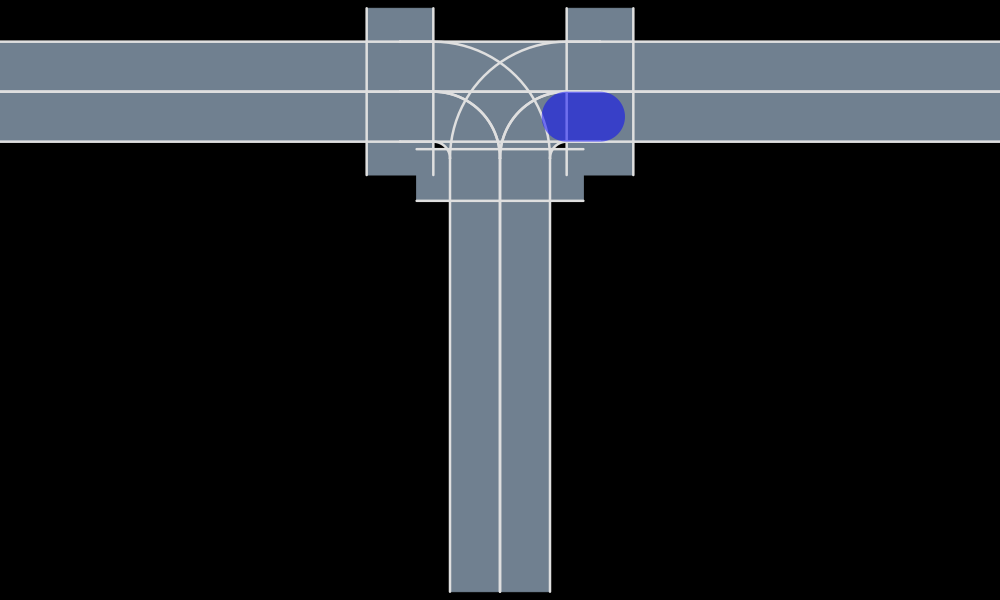

In [24]:
render(Scene(), env.roadway, [LaneOverlay(env.roadway[LaneTag(16,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))